In [1]:
import numpy as np
import matplotlib.pyplot as plt
import flopy
import os
import xmf6

In [6]:
init = {
    'sim_name' : "flow",
    'exe_name' : "C:\\Users\\luiggi\\Documents\\GitSites\\xmf6\\mf6\\windows\\mf6",
    'sim_ws' : "sandbox5"
}

time = {
    'units': "DAYS",
    'nper' : 1,
    'perioddata': [(1.0, 1, 1.0)]
}

ims = {}

gwf = { 
    'modelname': init["sim_name"],
    'model_nam_file': f"{init["sim_name"]}.nam",
    'save_flows': True
}

dis = {
    'nlay': 1, 
    'nrow': 20, 
    'ncol': 30,
    'delr': 0.5, 
    'delc': 0.5, 
    'top' : 0.0, 
    'botm': -1.0 
}

ic = {
    'strt': 10
}

chd_data = []
for row in range(dis['nrow']):
    chd_data.append([(0, row, 0), 10.0])       # Condición en la pared izquierda
    chd_data.append([(0, row, dis['ncol'] - 1), 5.0]) # Condición en la pared derecha

chd = {
    'stress_period_data': chd_data,     
}

k_data = np.random.rand(dis['nlay'], dis['nrow'], dis['ncol'])*1.0 
k_data[:, dis['nrow']//6 : dis['nrow']*5//6, dis['ncol']//3 : dis['ncol']*2//3] = 0.1

npf = {
    'save_specific_discharge': True,
    'k': k_data, 
}

well_data = [((0, dis['nrow']//2, dis['ncol']*2//3), -1.0)]

well = {
    'stress_period_data': well_data,
    'pname': "WEL-1",
    'save_flows': True
}

oc = {
    'budget_filerecord': f"{init['sim_name']}.bud",
    'head_filerecord': f"{init['sim_name']}.hds",
    'saverecord': [("HEAD", "ALL"), ("BUDGET", "ALL")],
    'printrecord': [("HEAD", "ALL")]
}

o_sim = xmf6.gwf.initialize(silent = True, init = init, time = time, ims = ims)
o_gwf = xmf6.gwf.build(o_sim, silent = True,
                       gwf = gwf, dis = dis, ic = ic, chd = chd, npf = npf, oc = oc, well = well)

o_sim.write_simulation(silent = True)
o_sim.run_simulation(silent = True)

(True, [])

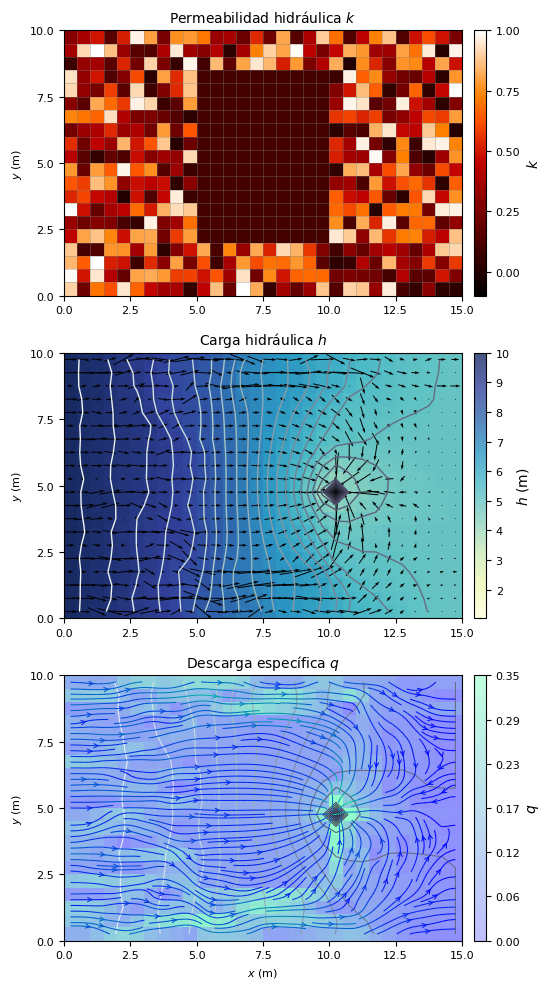

In [7]:
# --- Recuperamos los resultados de la simulación ---
head = xmf6.gwf.get_head(o_sim, o_gwf)
qx, qy, qz, n_q = xmf6.gwf.get_specific_discharge(o_sim, o_gwf)

# --- Parámetros para las gráficas ---
grid = o_gwf.modelgrid
x, y, z = grid.xyzcellcenters
xticks = np.linspace(grid.extent[0], grid.extent[1], 7)
yticks = np.linspace(grid.extent[2], grid.extent[3], 5)
xlabels = [f'{x:1.1f}' for x in xticks]
ylabels = [f'{y:1.1f}' for y in yticks]
kvmin = 1.0 #np.nanmin(k_data)
kvmax = 0.0 #np.nanmax(k_data)
hvmin = np.nanmin(head)
hvmax = np.nanmax(head)
qvmin = 0.00 #np.nanmin(n_q)
qvmax = 0.35 #np.nanmax(n_q)

# --- Definición de la figura ---
fig, (ax1, ax2, ax3) = plt.subplots(3, 1, figsize =(10,10))

# --- Gráfica 1. ---
kview = flopy.plot.PlotMapView(model = o_gwf, ax = ax1)
kview.plot_grid(linewidths = 0.5, alpha = 0.5)
k_ac = kview.plot_array(k_data, cmap = "gist_heat", vmin = kvmin, vmax = kvmax)
k_cb = plt.colorbar(k_ac, ax = ax1, label = "$k$", 
                    ticks = [0.0, 0.25, 0.50, 0.75, 1.0],
                    cax = xmf6.vis.cax(ax1, k_ac))
k_cb.ax.tick_params(labelsize=8)
ax1.set_title("Permeabilidad hidráulica $k$", fontsize=10)
ax1.set_ylabel("$y$ (m)", fontsize = 8)
ax1.set_xticks(ticks = xticks, labels = xlabels, fontsize = 8)
ax1.set_yticks(ticks = yticks, labels = ylabels, fontsize = 8)
ax1.set_aspect('equal')

# --- Gráfica 2. ---
hview = flopy.plot.PlotMapView(model = o_gwf, ax = ax2)
h_ac = hview.plot_array(head, cmap = "YlGnBu", vmin = hvmin, vmax = hvmax, alpha = 0.75)
hview.contour_array(head, levels = 30, cmap = "bone", linewidths = 1.0)
ax2.quiver(x, y, qx[0], qy[0], scale = 3, 
           color = 'k', linewidth = 0.95, pivot = 'middle')
h_cb = plt.colorbar(h_ac, ax = ax2, label = "$h$ (m)", 
                    cax = xmf6.vis.cax(ax2, h_ac))
h_cb.ax.tick_params(labelsize=8)
ax2.set_title("Carga hidráulica $h$", fontsize=10)
ax2.set_ylabel("$y$ (m)", fontsize = 8)
ax2.set_xticks(ticks = xticks, labels = xlabels, fontsize = 8)
ax2.set_yticks(ticks = yticks, labels = ylabels, fontsize = 8)
ax2.set_aspect('equal')

# --- Gráfica 3. ---
fview = flopy.plot.PlotMapView(model = o_gwf, ax = ax3)
q_ac = fview.plot_array(n_q, cmap = "winter", vmin = qvmin, vmax = qvmax, alpha = 0.25)
fview.contour_array(head, levels = 20, cmap = 'bone', linewidths = 0.75, )
ax3.streamplot(x, y[::-1][:], qx[0], qy[0][::-1], 
               density = [2, 1.5], linewidth = 0.75, broken_streamlines = True, 
               color = n_q, cmap = "winter", 
               arrowstyle = "->", arrowsize = 0.75,  )
q_cb = plt.colorbar(q_ac, ax=ax3, label="$q$", 
                    ticks = np.linspace(0.0, 0.35, 7),
                    format = "{x:3.2f}",
                    cax = xmf6.vis.cax(ax3, q_ac))
q_cb.ax.tick_params(labelsize=8)
ax3.set_title("Descarga específica $q$", fontsize=10)
ax3.set_xlabel("$x$ (m)", fontsize = 8)
ax3.set_ylabel("$y$ (m)", fontsize = 8)
ax3.set_xticks(ticks = xticks, labels = xlabels, fontsize = 8)
ax3.set_yticks(ticks = yticks, labels = ylabels, fontsize = 8)
ax3.set_aspect('equal')

plt.tight_layout()
plt.savefig("05_MF6.pdf")
plt.show()